Catboost - 90 day churn

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

2022-11-10 01:45:06.851139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 01:45:06.997166: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 01:45:07.659498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7']


2022-11-10 01:45:08.582103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 01:45:12.649935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 38407 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-10 01:45:12.651941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 38407 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-11-10 01:45:12.653774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 38407 MB memory:  -> device: 2, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capab

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib
import time

from catboost import CatBoostClassifier

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

!pip install ipywidgets
!pip install catboost
import ipywidgets
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [5]:
%cd ..

/workspace/asurion_f22


In [6]:
test = pd.read_csv('fe_data/90_day_churn_data/test_90d_encoded.csv')

In [7]:
len(test)

19718

In [8]:
test

,id,quality_sale,ninety_day_churn,clndr_dt_cst,start_dt,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,zipcode,county,state,state_code,latitude,longitude,month,hh_income_code,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
0,317874eac956ff7012276c7afd08c2730a125245715fd6...,1,0.00,2022-07-06 00:00:00.000,2022-07-06 14:44:27.442,2,1,156,2,0,1,SD,android,2382862,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,5 Rural,32174,7651,54,22,17,11,23,73,28383.00,Rowland,North Carolina,NC,34.59,-79.26,july,2,Wednesday,14,0.14,42.00,7.00,49.00
1,22bc3339395ce4596ec639654dbec6c6c7f8559b80f828...,1,0.00,2022-07-11 00:00:00.000,2022-07-11 14:10:11.794,8,5,2049,0,9,1,MD,android,2599576,Low-Tech,6 Downscale,3 Older,4 High School,4 Mostly w/o Kids,5 Renters,7 Metro Mix,56187,35206,52,22,14,43,50,1011,29209.00,Columbia,South Carolina,SC,33.97,-80.94,july,6,Monday,14,0.14,114.00,19.00,133.00
2,3af4175c07e6d614d87cf494c8c82a64f254e959f9d90b...,1,0.00,2022-07-15 00:00:00.000,2022-07-15 10:20:57.256,1,1,297,1,2,1,SD,android,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,66949,45958,53,21,17,70,10,3302,74133.00,Tulsa,Oklahoma,OK,36.05,-95.88,july,8,Friday,10,0.10,56.00,6.00,62.00
3,e435c44b5da45891633ebf793580e1083a87891326c46a...,1,0.00,2022-07-06 00:00:00.000,2022-07-06 14:37:15.232,2,8,1964,1,5,1,SD,android,1762649,Mid-Tech,7 Low Income,1 Younger,4 High School,1 w/ Kids,4 Mostly Renters,7 Metro Mix,81776,26823,50,20,15,83,1,2004,98372.00,Puyallup,Washington,WA,47.20,-122.27,july,7,Wednesday,14,0.10,53.00,6.00,59.00
4,9862f30eb37672ac8858d9c63422992df77c4883c30f2e...,1,0.00,2022-07-07 00:00:00.000,2022-07-07 15:25:41.181,1,1,805,1,0,1,SD,android,1709645,High-Tech,4 Midscale,1 Younger,4 High School,1 w/ Kids,3 Mix,5 Rural,32000,6893,42,16,17,34,61,55,23868.00,Lawrenceville,Virginia,VA,36.73,-77.81,july,4,Thursday,15,0.13,40.00,6.00,46.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19713,3e220e529b83c032b08f5cb3207e2ff91b5c297686158f...,1,1.00,2022-07-07 00:00:00.000,2022-07-07 18:36:11.049,1,2,4698,0,0,0,SD,other,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,0,0,0,0,0,0,36072.00,Eufaula,Alabama,AL,31.89,-85.15,july,8,Thursday,18,1.00,0.00,1.00,1.00
19714,f89873ec5ca10b4f4ea7d9b5c93829803887926b9daec8...,1,1.00,2022-07-28 00:00:00.000,2022-07-28 07:52:24.471,5,5,4126,1,3,0,MD,other,1709645,High-Tech,4 Midscale,1 Younger,4 High School,1 w/ Kids,3 Mix,5 Rural,49706,3975,54,23,21,83,4,46,28756.00,Mill Spring,North Carolina,NC,35.33,-82.16,july,4,Thursday,7,0.00,22.00,0.00,22.00
19715,381f00671cc75757e16e75b11880a3b43b41175c0a2306...,1,0.00,2022-07-21 00:00:00.000,2022-07-21 11:19:42.098,1,1,269,0,4,0,SD,other,2410425,High-Tech,3 Upper Midscale,1 Younger,2 College Graduate,5 w/o Kids,1 Homeowners,7 Metro Mix,68949,29416,51,22,16,71,11,1819,12303.00,Schenectady,New York,NY,42.78,-73.94,july,3,Thursday,11,0.05,73.00,4.00,77.00
19716,562cbb9e5b568e5b1e12093bce7c561d976314a959b98a...,1,0.00,2022-07-14 00:00:00.000,2022-07-14 16:03:05.390,4,1,2894,0,0,0,MD,other,2680613,Mid-Tech,3 Upper Midscale,3 Older,3 Some College,4 Mostly w/o Kids,2 Mostly Owners,5 Rural,82560,16309,49,30,7,72,5,157,77447.00,Hockley,Texas,TX,30.07,-95.81,july,3,Thursday,16,0.13,58.00,9.00,67.00


In [9]:
test.columns

Index(['id', 'quality_sale', 'ninety_day_churn', 'clndr_dt_cst', 'start_dt',
       'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'zipcode', 'county', 'state', 'state_code', 'latitude', 'longitude',
       'month', 'hh_income_code', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers'],
      dtype='object')

In [10]:
dcols = ['quality_sale', 'clndr_dt_cst', 'start_dt', 'zipcode', 'county', 'state', 
         'state_code', 'latitude', 'longitude', 'month','hh_income_code']

In [11]:
test.drop(columns = dcols, inplace = True)
test = test[(test['zipcode_accepted_prop'].isnull()==False)& (test['zipcode_rejected_offers'].isnull()==False)& 
            (test['zipcode_accepted_offers'].isnull()==False)&(test['zipcode_total_offers'].isnull()==False)]

In [12]:
len(test)

18316

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18316 entries, 0 to 19717
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          18316 non-null  object 
 1   ninety_day_churn            18316 non-null  float64
 2   lines                       18316 non-null  int64  
 3   previous_tech_support_call  18316 non-null  int64  
 4   account_tenure              18316 non-null  int64  
 5   past_yr_claim_count         18316 non-null  int64  
 6   num_decline                 18316 non-null  int64  
 7   exp                         18316 non-null  int64  
 8   product_type                18316 non-null  object 
 9   pmake                       18316 non-null  object 
 10  claritas_hh_count           18316 non-null  int64  
 11  technodoption_class         18316 non-null  object 
 12  hh_income                   18316 non-null  object 
 13  age_class                   183

In [14]:
train = pd.read_csv('fe_data/90_day_churn_data/train_90d_encoded.csv')

In [15]:
len(train)

85707

In [16]:
len(train)

85707

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85707 entries, 0 to 85706
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          85707 non-null  object 
 1   quality_sale                85707 non-null  int64  
 2   ninety_day_churn            85707 non-null  float64
 3   clndr_dt_cst                85707 non-null  object 
 4   start_dt                    85707 non-null  object 
 5   lines                       85707 non-null  int64  
 6   previous_tech_support_call  85707 non-null  int64  
 7   account_tenure              85707 non-null  int64  
 8   past_yr_claim_count         85707 non-null  int64  
 9   num_decline                 85707 non-null  int64  
 10  exp                         85707 non-null  int64  
 11  product_type                85707 non-null  object 
 12  pmake                       85707 non-null  object 
 13  claritas_hh_count           857

In [18]:
train.head()

,id,quality_sale,ninety_day_churn,clndr_dt_cst,start_dt,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,zipcode,county,state,state_code,latitude,longitude,month,hh_income_code,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
0,68943556bf63277816d843ffb129e23ffe60bc5b982603...,1,0.00,2022-03-01 00:00:00.000,2022-03-01 12:22:15.780,2,4,689,1,8,1,SD,android,1715961,High-Tech,4 Midscale,1 Younger,3 Some College,1 w/ Kids,5 Renters,7 Metro Mix,49842,34512,48,27,9,74,11,1894,77301.00,Conroe,Texas,TX,30.31,-95.45,march,4,Tuesday,12,0.19,57.00,13.00,70.00
1,6c09cf1d3246c800ba864c7eaced4b1e7a38b09f90ebc3...,1,0.00,2022-03-17 00:00:00.000,2022-03-17 15:29:30.018,2,1,72,0,0,1,SD,android,3161699,Mid-Tech,4 Midscale,1 Younger,3 Some College,5 w/o Kids,4 Mostly Renters,7 Metro Mix,71662,41592,50,12,17,84,1,5533,85251.00,Scottsdale,Arizona,AZ,33.49,-111.92,march,4,Thursday,15,0.09,125.00,12.00,137.00
2,5221cde1976fcd8a4d0d6fb059e04ed6d9b6450b68020d...,1,0.00,2022-03-07 00:00:00.000,2022-03-07 09:11:47.002,2,1,237,0,0,1,SD,android,2444705,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,8 Mix,73514,41147,47,21,13,58,4,4466,7032.00,Kearny,New Jersey,NJ,40.76,-74.15,march,2,Monday,9,0.13,90.00,13.00,103.00
3,a68e921aeb079a7c79de714f566802dedde074721d40a4...,0,1.00,2022-03-04 00:00:00.000,2022-03-04 15:00:09.566,2,2,3062,2,0,1,SD,android,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,35982,485,39,0,48,99,0,8,3812.00,Bartlett,New Hampshire,NH,44.08,-71.29,march,8,Friday,15,0.00,1.00,0.00,1.00
4,b9b75e5295e70045ba4f1c4d0b5de77b6e03df31f200bc...,1,0.00,2022-03-04 00:00:00.000,2022-03-04 11:56:31.079,1,2,2585,0,1,1,SD,android,2843065,Low-Tech,3 Upper Midscale,4 Mature,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,8 Mix,89029,34659,52,17,21,81,1,4462,92672.00,San Clemente,California,CA,33.44,-117.62,march,3,Friday,11,0.08,129.00,11.00,140.00


In [19]:
len(train)

85707

In [20]:
train.drop(columns = dcols, inplace = True)
train = train[(train['zipcode_accepted_prop'].isnull()==False)& (train['zipcode_rejected_offers'].isnull()==False)& 
            (train['zipcode_accepted_offers'].isnull()==False)&(train['zipcode_total_offers'].isnull()==False)]

In [21]:
len(train)

84339

In [22]:
train.columns

Index(['id', 'ninety_day_churn', 'lines', 'previous_tech_support_call',
       'account_tenure', 'past_yr_claim_count', 'num_decline', 'exp',
       'product_type', 'pmake', 'claritas_hh_count', 'technodoption_class',
       'hh_income', 'age_class', 'hh_education', 'hh_composition', 'hh_tenure',
       'urbanicity', 'median_income', 'total_population', 'perc_female',
       'perc_under18', 'perc_over65', 'perc_white', 'perc_black',
       'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers'],
      dtype='object')

In [23]:
test.columns

Index(['id', 'ninety_day_churn', 'lines', 'previous_tech_support_call',
       'account_tenure', 'past_yr_claim_count', 'num_decline', 'exp',
       'product_type', 'pmake', 'claritas_hh_count', 'technodoption_class',
       'hh_income', 'age_class', 'hh_education', 'hh_composition', 'hh_tenure',
       'urbanicity', 'median_income', 'total_population', 'perc_female',
       'perc_under18', 'perc_over65', 'perc_white', 'perc_black',
       'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers'],
      dtype='object')

In [24]:
def transform_xy(dat):
    X_ori = dat[[
#         'emplid','cvp_call_id',
                 'lines', 'previous_tech_support_call','account_tenure', 'past_yr_claim_count', 
                'num_decline', 'exp', 
#                  'churn',
                 'product_type', 'pmake', 
                 'claritas_hh_count',
                 'technodoption_class', 'hh_income', 'age_class', 'hh_education',
                 'hh_composition', 'hh_tenure', 'urbanicity','median_income', 'total_population', 
                 'perc_female', 'perc_under18',
                'perc_over65', 'perc_white', 'perc_black', 'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers']]
    y = dat[['ninety_day_churn']]
   
    X_ori.loc[X_ori.lines.isnull(), 'lines'] = 0
    X_ori.exp = X_ori.exp.apply(int)
    X_ori.num_decline = X_ori.num_decline.apply(float)
    X_ori.loc[X_ori.account_tenure.isnull(), 'account_tenure'] = 0
    X_ori.loc[X_ori.claritas_hh_count.isnull(), 'claritas_hh_count'] = 0
    X_ori.loc[X_ori.exp.isnull(), 'exp'] = 'Unknown'
    X_ori.loc[X_ori.product_type.isnull(), 'product_type'] = 'Unknown'
    X_ori.loc[X_ori.pmake.isnull(), 'pmake'] = 'Unknown'
    X_ori.loc[X_ori.technodoption_class.isnull(), 'technodoption_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_income.isnull(), 'hh_income'] = 'Unknown'
    X_ori.loc[X_ori.age_class.isnull(), 'age_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_education.isnull(), 'hh_education'] = 'Unknown'
    X_ori.loc[X_ori.hh_composition.isnull(), 'hh_composition'] = 'Unknown'
    X_ori.loc[X_ori.hh_tenure.isnull(), 'hh_tenure'] = 'Unknown'
    X_ori.loc[X_ori.urbanicity.isnull(), 'urbanicity'] = 'Unknown'
    X_ori.loc[X_ori.day_of_week.isnull(), 'day_of_week'] = 'Unknown'
    X_ori.loc[X_ori.time_of_day.isnull(), 'time_of_day'] = 'Unknown'
    X_ori.loc[X_ori.zipcode_accepted_prop.isnull(), 'zipcode_accepted_prop'] = 0
    X_ori.loc[X_ori.zipcode_rejected_offers.isnull(), 'zipcode_rejected_offers'] = 0
    X_ori.loc[X_ori.zipcode_accepted_offers.isnull(), 'zipcode_accepted_offers'] = 0
    X_ori.loc[X_ori.zipcode_total_offers.isnull(), 'zipcode_total_offers'] = 0

    return X_ori,y

In [25]:
X,y = transform_xy(train)
x_hold_out, y_hold_out = transform_xy(test)

In [26]:
X['lines'] = X['lines'].astype(np.int) 
X['previous_tech_support_call'] = X['previous_tech_support_call'].astype('category')
X['num_decline'] = X['num_decline'].astype(np.int) 
X['past_yr_claim_count'] = X['past_yr_claim_count'].astype(np.int) 
X['exp'] = X['exp'].astype('category') 
X['account_tenure'] = X['account_tenure'].astype(np.int) 
X['pmake'] = X['pmake'].astype('category')
X['technodoption_class'] = X['technodoption_class'].astype('category')
X['claritas_hh_count'] = X['claritas_hh_count'].astype('category')
X['hh_income'] = X['hh_income'].astype('category')
X['age_class'] = X['age_class'].astype('category')
X['hh_education'] = X['hh_education'].astype('category')
X['hh_composition'] = X['hh_composition'].astype('category')
X['hh_tenure'] = X['hh_tenure'].astype('category')
X['urbanicity'] = X['urbanicity'].astype('category')
X['product_type'] = X['product_type'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')
X['time_of_day'] = X['time_of_day'].astype('category')
X['zipcode_accepted_prop'] = (X['zipcode_accepted_prop']*100).astype(np.int)
X['zipcode_rejected_offers'] = X['zipcode_rejected_offers'].astype(np.int)
X['zipcode_accepted_offers'] = X['zipcode_accepted_offers'].astype(np.int)
X['zipcode_total_offers'] = X['zipcode_total_offers'].astype(np.int)


X['median_income'] = X['median_income'].astype(np.int)
X['total_population'] = X['total_population'].astype(np.int)
X['perc_female'] = X['perc_female'].astype(np.int)
X['perc_under18'] = X['perc_under18'].astype(np.int)
X['perc_over65'] = X['perc_over65'].astype(np.int)
X['perc_white'] = X['perc_white'].astype(np.int)
X['perc_black'] = X['perc_black'].astype(np.int)
X['population_density'] = X['population_density'].astype(np.int)

In [27]:
x_hold_out['lines'] = x_hold_out['lines'].astype(np.int) 
x_hold_out['previous_tech_support_call'] = x_hold_out['previous_tech_support_call'].astype('category')
x_hold_out['num_decline'] = x_hold_out['num_decline'].astype(np.int) 
x_hold_out['past_yr_claim_count'] = x_hold_out['past_yr_claim_count'].astype(np.int) 
x_hold_out['exp'] = x_hold_out['exp'].astype('category') 
x_hold_out['account_tenure'] = x_hold_out['account_tenure'].astype(np.int) 
x_hold_out['pmake'] = x_hold_out['pmake'].astype('category')
x_hold_out['technodoption_class'] = x_hold_out['technodoption_class'].astype('category')
x_hold_out['claritas_hh_count'] = x_hold_out['claritas_hh_count'].astype('category')
x_hold_out['hh_income'] = x_hold_out['hh_income'].astype('category')
x_hold_out['age_class'] = x_hold_out['age_class'].astype('category')
x_hold_out['hh_education'] = x_hold_out['hh_education'].astype('category')
x_hold_out['hh_composition'] = x_hold_out['hh_composition'].astype('category')
x_hold_out['hh_tenure'] = x_hold_out['hh_tenure'].astype('category')
x_hold_out['urbanicity'] = x_hold_out['urbanicity'].astype('category')
x_hold_out['product_type'] = x_hold_out['product_type'].astype('category')
x_hold_out['day_of_week'] = x_hold_out['day_of_week'].astype('category')
x_hold_out['time_of_day'] = x_hold_out['time_of_day'].astype('category')
x_hold_out['zipcode_accepted_prop'] = (x_hold_out['zipcode_accepted_prop']*100).astype(np.int)
x_hold_out['zipcode_rejected_offers'] = x_hold_out['zipcode_rejected_offers'].astype(np.int)
x_hold_out['zipcode_accepted_offers'] = x_hold_out['zipcode_accepted_offers'].astype(np.int)
x_hold_out['zipcode_total_offers'] = x_hold_out['zipcode_total_offers'].astype(np.int)


x_hold_out['median_income'] = x_hold_out['median_income'].astype(np.int)
x_hold_out['total_population'] = x_hold_out['total_population'].astype(np.int)
x_hold_out['perc_female'] = x_hold_out['perc_female'].astype(np.int)
x_hold_out['perc_under18'] = x_hold_out['perc_under18'].astype(np.int)
x_hold_out['perc_over65'] = x_hold_out['perc_over65'].astype(np.int)
x_hold_out['perc_white'] = x_hold_out['perc_white'].astype(np.int)
x_hold_out['perc_black'] = x_hold_out['perc_black'].astype(np.int)
x_hold_out['population_density'] = x_hold_out['population_density'].astype(np.int)

In [28]:
len(x_hold_out)

18316

In [29]:
len(X)

84339

In [30]:
len(y)

84339

In [31]:
type(train)

pandas.core.frame.DataFrame

In [32]:
type(test)

pandas.core.frame.DataFrame

In [33]:
len(test)

18316

In [34]:
len(x_hold_out)

18316

In [35]:
len(y_hold_out)

18316

In [36]:
Xf_train, Xf_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify=y['ninety_day_churn'])

In [37]:
y_train.value_counts()

ninety_day_churn
0.00                41631
1.00                17406
dtype: int64

In [38]:
y_hold_out.value_counts()

ninety_day_churn
0.00                13427
1.00                 4889
dtype: int64

In [40]:
Xf_train.columns

Index(['lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers'],
      dtype='object')

In [41]:
y_train.value_counts()

ninety_day_churn
0.00                41631
1.00                17406
dtype: int64

In [42]:
y_train.head

<bound method NDFrame.head of        ninety_day_churn
73622              1.00
67214              0.00
65587              0.00
30952              0.00
14252              0.00
...                 ...
84619              0.00
13572              1.00
50574              0.00
62780              0.00
37680              0.00

[59037 rows x 1 columns]>

In [43]:
spw = (y_train['ninety_day_churn'] == 0.00).sum()/(y_train['ninety_day_churn'] == 1.00).sum()
spw

2.3917614615649776

In [44]:
x_hold_out.shape

(18316, 30)

In [45]:
train_census_dataset = cb.Pool(Xf_train,y_train, 
                        cat_features=np.where(Xf_train.dtypes != np.int)[0])                                                      
test_census_dataset = cb.Pool(Xf_test, y_test,           
                       cat_features=np.where(Xf_test.dtypes != np.int)[0])

In [46]:
holdout_census_dataset = cb.Pool(x_hold_out, y_hold_out,           
                       cat_features=np.where(x_hold_out.dtypes != np.int)[0])

In [47]:
from catboost import CatBoostClassifier

In [48]:
#initiate model
cat_model_census = CatBoostClassifier(
    cat_features = np.where(Xf_train.dtypes != np.int)[0],
    scale_pos_weight=spw,
    max_depth = 5,
    learning_rate = 0.05
)
#train
cat_model_census.fit(train_census_dataset, 
       eval_set=test_census_dataset,
      plot=True, silent= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [49]:
y_hold_out.value_counts()
#26%

ninety_day_churn
0.00                13427
1.00                 4889
dtype: int64

In [50]:
pred_census = cat_model_census.predict_proba(holdout_census_dataset)
threshold=0.5
predicted_cat_census = (pred_census[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_hold_out, predicted_cat_census).ravel()
print("catboost_holdoutset",'\n',
    "recall:",recall_score(y_hold_out, predicted_cat_census),'\n',
     'precision',precision_score(y_hold_out, predicted_cat_census),'\n',
     confusion_matrix(y_hold_out, predicted_cat_census),'\n',
     'f1 score:',f1_score(y_hold_out, predicted_cat_census),'\n',
     'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_holdoutset 
 recall: 0.45346696665984865 
 precision 0.3244548514561686 
 [[8811 4616]
 [2672 2217]] 
 f1 score: 0.378263095034977 
 tn:8811, fp:4616, fn:2672, tp:2217 



In [51]:
y_test.value_counts()
#29% 

ninety_day_churn
0.00                17842
1.00                 7460
dtype: int64

In [57]:
pred_census = cat_model_census.predict_proba(test_census_dataset)
threshold=0.5
predicted_cat_census = (pred_census[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_test, predicted_cat_census).ravel()
print("catboost_testset",'\n',
    "recall:",recall_score(y_test, predicted_cat_census),'\n',
     'precision',precision_score(y_test, predicted_cat_census),'\n',
     confusion_matrix(y_test, predicted_cat_census),'\n',
     'f1 score:',f1_score(y_test, predicted_cat_census),'\n',
     'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_testset 
 recall: 0.5198391420911528 
 precision 0.4355835111760081 
 [[12817  5025]
 [ 3582  3878]] 
 f1 score: 0.4739962109637597 
 tn:12817, fp:5025, fn:3582, tp:3878 



In [53]:
vip = cat_model_census.feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':Xf_train.columns, 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info.head(15)

,vip,feature_importances_mag,feature_importances_sign
feat_names,,,
lines,14.57,14.57,1.00
zipcode_accepted_offers,9.28,9.28,1.00
account_tenure,7.25,7.25,1.00
zipcode_accepted_prop,6.96,6.96,1.00
median_income,5.39,5.39,1.00
previous_tech_support_call,5.09,5.09,1.00
population_density,4.25,4.25,1.00
num_decline,4.03,4.03,1.00
total_population,3.38,3.38,1.00


In [54]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


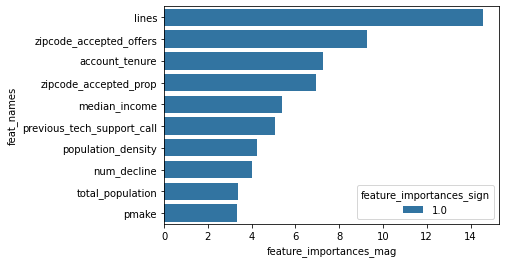

In [55]:
import seaborn as sns
sns.barplot(y=feature_importances_info.index[:10], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:10], orient='h', dodge=False);

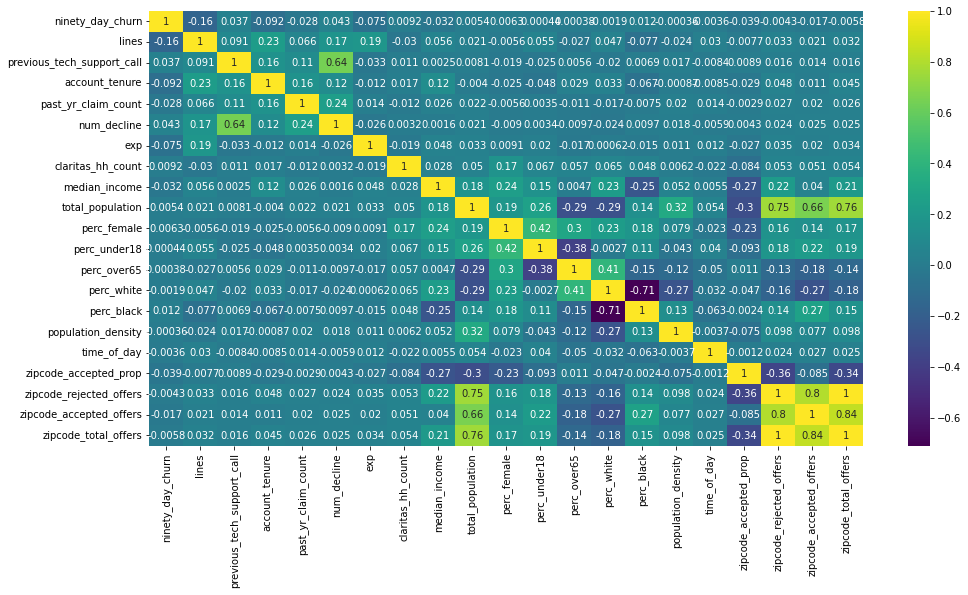

In [56]:
plt.figure(figsize = (16,8))
cor = train.corr()
sns.heatmap(cor, annot = True, cmap = "viridis")
plt.show()